## Stackoverflow survey (2011-2021) exploration ##

### Business / real-world questions: ###

**1.** Has the background of people approaching the programming world changed over the recent years? And therefore, what kind of people represent a suitable market for IT companies?

**2.** Has the programming language of reference changed over the years? Therefore, which programming language should one acquire to be stronger on the market?

**3.** Once we know the programming language(s) of reference now, do they also predict the highest remuneration for who works using them? 

In [1]:
# Imports:

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from collections import defaultdict
%matplotlib inline


In [2]:
# Let's set the main dir and move where we have our zip files.

years = list(range(2011,2022)) # 2011-2021
main_dir = os.getcwd() # set the current directory as main directory
os.chdir(main_dir + '/zip_datasets') # move into the directory where the zip datasets are

In [4]:
# Import all the datasets from the Stackoverflow survey and unzip them in specific subdirectories, according to year
# which are created iteratively

for y in years: 
    target_dir = main_dir + '/unzip_datasets/' + str(y) # subdirectory 
    os.makedirs(target_dir) # create the subdirectory
    with zipfile.ZipFile('stack-overflow-developer-survey-' + str(y) + '.zip') as zf:
        zf.extractall(target_dir) # extract into that directory
    

In [8]:
# Now we read all the the CSV files and we save them in different datasets according to the different years
# Since this process can take a bit, to reduce time I ask the script to skip corrupted rows and to not use too much memory
# it will take about 5 mins. so grab a coffe in the meanwhile maybe :)

import chardet # we need this library to detect the encoding of older CSV files

d = {} # create a dictionary in which we store every year dataframe
for y in years:
    if y == 2016: # in 2016 we have an ulterior subdirectory which we need to move into to read the CSV
        os.chdir(main_dir + '/unzip_datasets/' + str(y) + '/2016 Stack Overflow Survey Results')
    else:
        os.chdir(main_dir + '/unzip_datasets/' + str(y))
    if y in range(2016,2018): # we need to adjust the index for years 2015,2016,2017 to read the CSV file and not something else
        filen = os.listdir()[2]
    elif y == 2015:
        filen = os.listdir()[1]
    else:
        filen = os.listdir()[0]
    rawdata = open(filen, "rb").read() # open the file as binary so that we can detect encoding type
    enc = chardet.detect(rawdata)['encoding'] # read the encoding type
    d['df_' + str(y)]  = pd.read_csv(filen,encoding = enc, error_bad_lines = False, low_memory = True)
    print(filen + ' succesfully imported')
print('all dataframes imported')
    


2011 Stack Overflow Survey Results.csv succesfully imported
2012 Stack Overflow Survey Results.csv succesfully imported
2013 Stack Overflow Survey Responses.csv succesfully imported
2014 Stack Overflow Survey Responses.csv succesfully imported


/Users/riccardogalli/miniconda3/envs/notebook-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,108,121,196,197,198) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2015 Stack Overflow Developer Survey Responses.csv succesfully imported
2016 Stack Overflow Survey Responses.csv succesfully imported
survey_results_public.csv succesfully imported


/Users/riccardogalli/miniconda3/envs/notebook-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


survey_results_public.csv succesfully imported
survey_results_public.csv succesfully imported
survey_results_public.csv succesfully imported
survey_results_public.csv succesfully imported
all dataframes imported


As we can see, not all datasets are in good shape or are correctly uploaded. For later statistics we only focus on gender and country of origin (which are stable across datasets). Dataset 2015 is not included in the next steps as the headers are not correctly imported.

### Developers' background ###

Now we can try to observe how the background of the participants has changed over the years. We will focus on sociodemographic factors such as country of origin and gender, which are the most common features in every dataset and should have been correctly uploaded. We can therefore see which country represent the most promising market for IT and whether IT is a gender biased world.

In [9]:
## Country of origin
# we will create a dictionary storing the percentage of respondents from the different countries according to each df.

country_perc = {} # initialize dataframe
dfs = list(d.keys())
dfs.remove('df_2015') # bad upload
for df in dfs:
    if df in ['df_2011','df_2012','df_2013']:
        country_key = 'What Country or Region do you live in?'
    elif df == 'df_2014':
        country_key = 'What Country do you live in?'
    elif df == 'df_2016':
        country_key = 'country'
    elif df in ['df_2017','df_2018','df_2019','df_2020','df_2021']:
        country_key = 'Country'
    country_perc[df] = d[df][country_key].value_counts()/d[df].shape[0]
    
country_perc

{'df_2011': United States of America    0.368515
 Other Europe                0.160270
 United Kingdom              0.111585
 Canada                      0.055437
 Australia                   0.039801
 Germany                     0.037669
 India                       0.033760
 South America               0.032338
 Other Asia                  0.028785
 Middle East                 0.025942
 France                      0.021322
 Netherlands                 0.019545
 Africa                      0.015281
 Russia                      0.014570
 Italy                       0.012438
 Australasia                 0.010306
 Mexico                      0.007107
 North America (Other)       0.002843
 Central America             0.002132
 Response                    0.000355
 Name: What Country or Region do you live in?, dtype: float64,
 'df_2012': United States of America    0.285874
 Other Europe                0.187060
 United Kingdom              0.094331
 India                       0.086003
 Ca

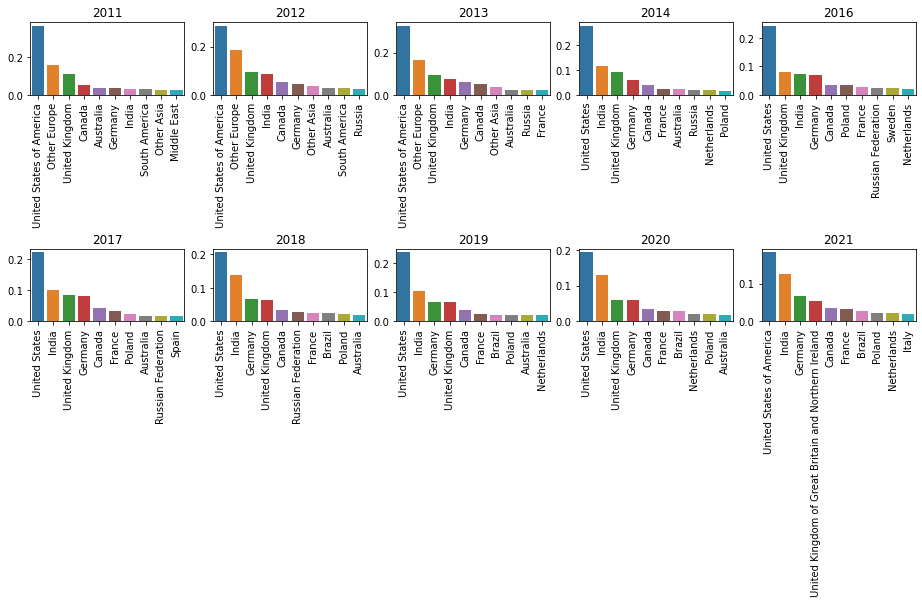

In [12]:
# Let's plot the participants' percentages by country across the years:

fig, axes = plt.subplots(nrows = 2, ncols = 5, constrained_layout = True, figsize = (12.7,8.27)) # we make subplots
c = 0 # counter to iteratively index the right dataframe
for ax in axes.flatten():
    # plot
    ax = sns.barplot(x = country_perc[dfs[c]][:10].index, y = country_perc[dfs[c]][:10].values, ax = ax) # bar plot of the top 10 values
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90) # rotate the x labels
    ax.title.set_text(dfs[c][-4:]) # give a title
    c = c + 1 # update the counter

It appears that USA has been the country where most responders come from, across the years. However, what is interesting here is the increasing contribution of India, which allowed it to move from 7th place to steadily 2nd from 2017 onwards. India could therefore represent a solid market, apart from US, to hire new employees or sell IT products. Let's now give a look at possible gender differences.

In [13]:
## Gender of respondents

gender_perc = {}
dfs = list(d.keys())
dfs = [e for e in dfs if e not in ('df_2011','df_2012','df_2013','df_2014','df_2015','df_2016')] # in these datasets gender was not recorded
for df in dfs:
    gender_key = 'Gender'
    gender_perc[df] = d[df][gender_key].value_counts()/d[df].shape[0]
gender_perc

{'df_2017': Male                                                       0.614668
 Female                                                     0.050592
 Other                                                      0.004378
 Male; Other                                                0.003327
 Gender non-conforming                                      0.003113
 Male; Gender non-conforming                                0.001265
 Female; Transgender                                        0.001090
 Transgender                                                0.001070
 Female; Gender non-conforming                              0.000564
 Male; Female                                               0.000292
 Transgender; Gender non-conforming                         0.000292
 Male; Female; Transgender; Gender non-conforming; Other    0.000292
 Male; Transgender                                          0.000214
 Female; Transgender; Gender non-conforming                 0.000156
 Male; Female; Transgen

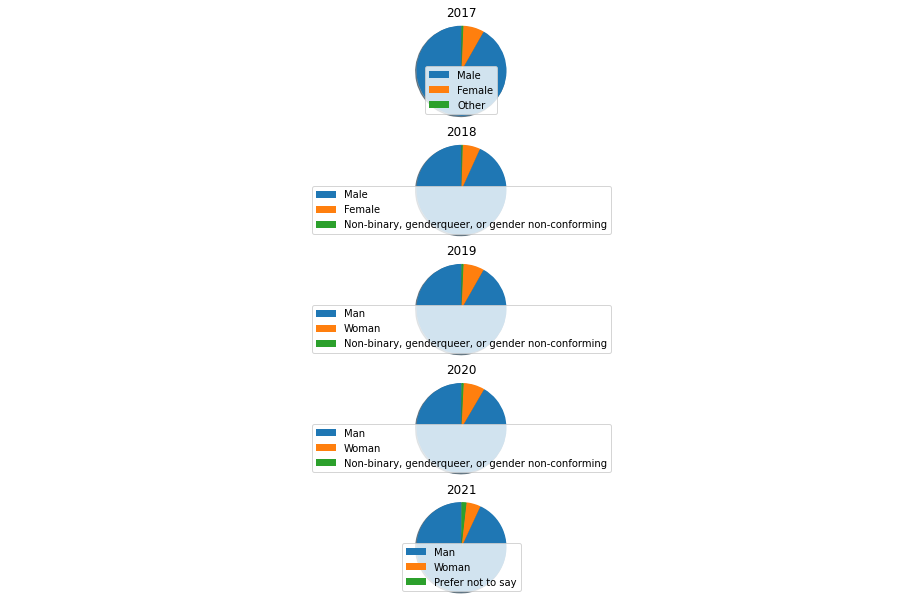

In [15]:
# Plot gender or respondents across the last 4 years of the survey:

fig, axes = plt.subplots(nrows = 5, ncols = 1, constrained_layout = True, figsize = (12.7,8.27))
c = 0
for ax in axes.flatten():
    # plot
    patches, texts = ax.pie(gender_perc[dfs[c]][:3].values, normalize = True, shadow = True, startangle = 90) # pie chart
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.legend(patches, gender_perc[dfs[c]][:3].index, loc = 'lower center')
    ax.title.set_text(dfs[c][-4:])
    c = c + 1

We can clearly observe that, in proportion, males have been the majority of responders across the last few years (compared to females and others), which makes clear how a gender gap is still present amongst the developers and computer science world.

### Programming language trend across the years ###

We will now see which one has been the main language used for working amongst developers that participated to the survey.

In [16]:
# Language of use, we need to change the key for different datasets as they were encoded differently

language_perc = {}
dfs = list(d.keys())
dfs.remove('df_2015')
for df in dfs:
    language_key = 'Which languages are you proficient in?'
    if df in ('df_2013','df_2014'):
        language_key = 'Which of the following languages or technologies have you used significantly in the past year?'
    elif df in ('df_2016'):
        language_key = 'tech_do'
    elif df in ('df_2017'):
        language_key = 'HaveWorkedLanguage'
    elif df in ('df_2018','df_2019','df_2020',''):
        language_key = 'LanguageWorkedWith'
    elif df == 'df_2021':
        language_key = 'LanguageHaveWorkedWith'
    language_perc[df] = d[df][language_key].value_counts()/d[df].shape[0]

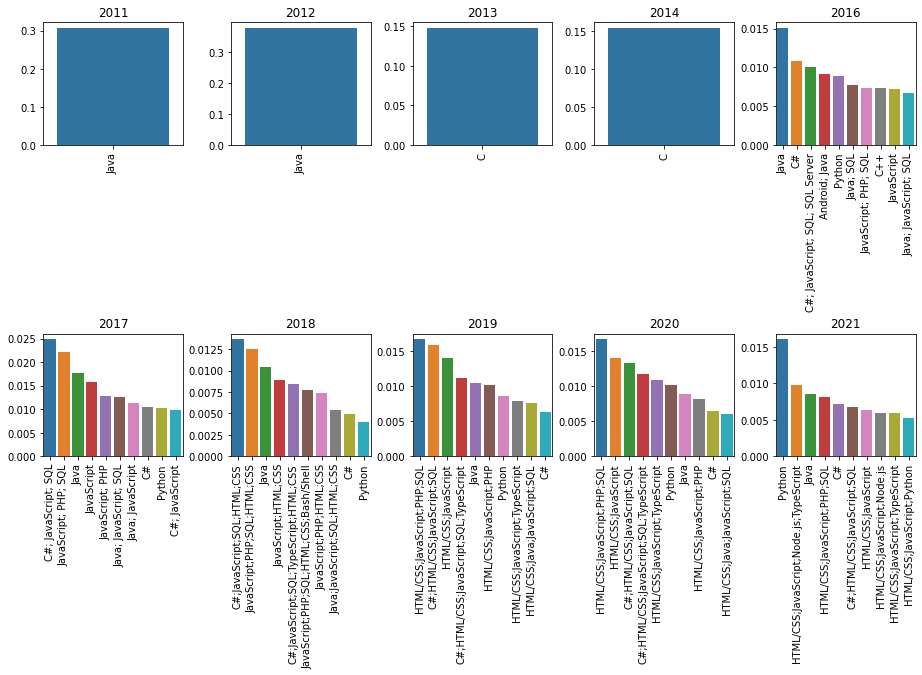

In [17]:
# let's plot the most used languages

fig, axes = plt.subplots(nrows = 2, ncols = 5, constrained_layout = True, figsize = (12.7,9.27))
c = 0
for ax in axes.flatten():
    # plot
    ax = sns.barplot(x = language_perc[dfs[c]][:10].index, y = language_perc[dfs[c]][:10].values, ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.title.set_text(dfs[c][-4:])
    c = c + 1

As we can see we have a bit of confusion across the last datasets as participants were allowed to reply using multiple choices, we need to clean this to get a better idea.

In [18]:
# two functions that we need for cleaning the mess about the languages

def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending = False, inplace = True)
    return new_df

def clean_and_plot(df,var_name, title = 'Programming language preferred', plot = True):
    '''
    INPUT 
        df - a dataframe holding the var_name column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        cln_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the var_name column.
    '''
    cln = df[var_name].value_counts().reset_index()
    cln.rename(columns={'index': 'Language', var_name: 'count'}, inplace = True)
    cln_df = total_count(cln, 'Language', 'count', possible_vals)

    cln_df.set_index('Language', inplace = True)
    if plot:
        (cln_df/cln_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_cln_df = cln_df/cln_df.sum()
    return props_cln_df    

In [19]:
possible_vals = ['Java','Javascript','C#','C','SQL','SQL Server','Android',
                 'PHP','C++','Python','HTML/CCS','Android','HTML',
                'CSS','TypeScript','Bash/Shell'] # possible languages answer, needed for clean_and_plot

# let's clean the data:

language_cleaned = {}
dfs = list(d.keys())
dfs.remove('df_2015')

for df in dfs:
    language_key = 'Which languages are you proficient in?'
    if df in ('df_2013','df_2014'):
        language_key = 'Which of the following languages or technologies have you used significantly in the past year?'
    elif df in ('df_2016'):
        language_key = 'tech_do'
    elif df in ('df_2017'):
        language_key = 'HaveWorkedLanguage'
    elif df in ('df_2018','df_2019','df_2020'):
        language_key = 'LanguageWorkedWith'
    elif df == 'df_2021':
        language_key = 'LanguageHaveWorkedWith' 
    language_cleaned[df] = clean_and_plot(d[df],var_name = language_key, plot = False) # we do not need the plot, we will do later

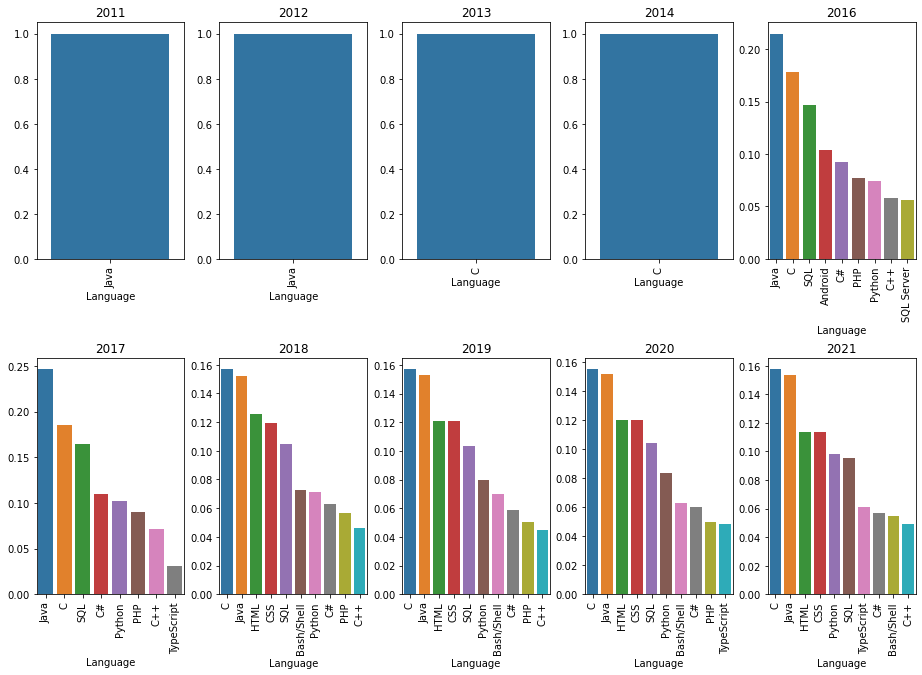

In [20]:
# now we plot the languages again, after cleaning

fig, axes = plt.subplots(nrows = 2, ncols = 5, constrained_layout = True, figsize = (12.7,9.27))
c = 0
for ax in axes.flatten():
    # plot
    ax = sns.barplot(x = language_cleaned[dfs[c]][:10].index, y = language_cleaned[dfs[c]]['count'][:10].values, ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.title.set_text(dfs[c][-4:])
    c = c + 1

What we can observe is that the majority developers use (or has used) C and Java. However, it is also clear that the developers' community has become increasingly diverse, thus allowing market for other languages.

### Job opportunities for Java and C developers ###

We will now try to see whether being a Java or C developer is able to successfully predict a high salary more than other languages.

In [21]:
# we will use only the 2017 survey

df_model = pd.read_csv(main_dir + '/unzip_datasets/2017/survey_results_public.csv')

# and we are interested in the salary and programming languages variable
df_model = df_model[['Salary','HaveWorkedLanguage']]

# let's clean the data, Salary is our target variable
df_model_c = df_model.dropna(subset = ['Salary'])

# let's get the highest portion of salaries (top 50%)
df_model_c = df_model_c.sort_values(by = 'Salary',  ascending = False)
df_model_c = df_model_c[:np.round(df_model_c.shape[0]/2).astype(int)]

# we have a 0.1 percent of missing values in the language variable, we can use it without problem.
# However, we need to dummy it
df_model_c['HaveWorkedLanguage'].isnull().mean()

# for this we will use a custom made function

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col,axis = 1),pd.get_dummies(df[col],prefix = col, prefix_sep = '_', drop_first = True, dummy_na = dummy_na)],axis = 1)
        except:
            continue
    return df

df_model_c_final = create_dummy_df(df_model_c, cat_cols = ['HaveWorkedLanguage'], dummy_na = False) # our final dummy dataset


In [22]:
# now we can create a model, we will use a linear regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error


X = df_model_c_final.drop('Salary',axis = 1) # all the dummy variables as predictors 
y = df_model_c_final['Salary'] # predict (high) salary
                      
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .3, random_state = 42) # randomly splitting the test, random_state is useful to have the very same split

lm_model = LinearRegression(normalize = True)
lm_model.fit(X_train,y_train) #fitting the model


LinearRegression(normalize=True)

In [23]:
# we can now predict salary and extract metrics of validity + the weight of the most important variables contributing to the model

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


y_preds = lm_model.predict(X_test) # predict using the test set
mse = mean_squared_error(y_preds,y_test) # calculate mse
r2 = r2_score(y_preds,y_test) # calculate r2
coef_df = coef_weights(lm_model.coef_, X_train) # extract parameters coefficients

print('our mse is: %.2f' %mse)
print('our r2 is: %.5f' %r2)
coef_df.head()

our mse is: 1316605110573092635512531373763445391360.00
our r2 is: -0.00371


,est_int,coefs,abs_coefs
1679,HaveWorkedLanguage_Go; R; Ruby; Scala,-3.394615e+20,3.394615e+20
1626,HaveWorkedLanguage_Go; Java; JavaScript; Perl;...,-2.324409e+20,2.324409e+20
1934,HaveWorkedLanguage_Java; Python; SQL; VBA,2.319068e+20,2.319068e+20
1377,HaveWorkedLanguage_C; Lua; R; SQL,1.976301e+20,1.976301e+20
1970,HaveWorkedLanguage_JavaScript; Objective-C; PH...,-1.965421e+20,1.965421e+20


Java and C are indeed present amongst the combinations which influences our predictions the most. However, the R2 and MSE metrics are so poor that we defintively rule out our model as valid. Therefore, high salary cannot be predict only as a combination of languages learned/used (how suprising!)